In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

%matplotlib inline

In [2]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

i = 0
tlen = 0

metaData = np.empty((0,17), dtype=float)
metaDataIndex = ['time',
                 'lat', 
                 'lon',
                 'U10N_AS',
                 'U10N_dir_AS',
                 'satTimeDiff',
                 'dist',
                 'satLon',
                 'satLat',
                 'U10N_TAO',
                 'U10N_dir_TAO',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'wspdVar2hr_TAO', 
                 'wdirVar2hr_TAO',
                 'Deployment Classifier']

for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ2/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2007.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ2/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):

        ds = Dataset(matchFname)
        arr = np.empty((0,1), dtype=float)
        for i in range(3,16):
            if i <= 8:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][0,:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                if len(arr) == 0:
                    arr = np.concatenate((arr, readArr), axis = 0)
                else:
                    arr = np.concatenate((arr, readArr), axis = 1)
            else:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                arr = np.concatenate((arr, readArr), axis = 1)

        latArr = np.array([len(arr)*[LAT]]).T
        lonArr = np.array([len(arr)*[LON]]).T
        timeArr = np.array(ds.variables['time'])

        # latArr = latArr[:,np.newaxis]
        # lonArr = lonArr[:,np.newaxis]
        timeArr = timeArr[:,np.newaxis]
        
        #print('lonArr', lonArr.shape)
        arr = np.concatenate((lonArr, arr), axis=1)

        #print('latArr', latArr.shape)
        arr = np.concatenate((latArr, arr), axis=1)

        #print('timeArr', timeArr.shape)
        arr = np.concatenate((timeArr, arr), axis=1)

        ds2 = Dataset(deployFileName)
        startDates = np.array(ds2.variables['startDate'])
        endDates = np.array(ds2.variables['endDate'])

        depNum = np.zeros((len(arr),1), dtype=int)
        c = 1
        for i in range(1,len(startDates)):
            mask = timeArr >= startDates[i]
            mask *= timeArr <= endDates[i]
            depNum[mask] = c
            c = c+1

        arr = np.concatenate((arr, depNum), axis=1)

        #print(arr.shape, metaData.shape)
        metaData = np.concatenate((metaData, arr), axis=0)
        ds.close()
        ds2.close()
        #ds = ds.expand_dims('lat', axis= 0)
        



In [3]:
nanVals = np.sum(metaData[:,:-2], axis=1)
mask = np.isnan(nanVals)
print(np.sum(mask), metaData.shape)
metaData = metaData[~mask, :]
print(metaData.shape)

1714 (60202, 17)
(58488, 17)


In [4]:
df = pd.DataFrame(metaData, columns = metaDataIndex )
df['speedDiff'] = df['U10N_AS'] - df['U10N_TAO']
df['absSpeedDiff'] = abs(df['U10N_AS'] - df['U10N_TAO'])

dDiff = (df['U10N_dir_AS'] - df['U10N_dir_TAO'])%360
dDiff[dDiff > 180] -= 360 #- dDiff[dDiff > 180] 
dDiff[dDiff < -180] += 360
df['directionDiff'] = dDiff
df['absDirectionDiff'] = abs(dDiff)

df['U10N_x_TAO'] = df['U10N_TAO'] * np.cos(np.deg2rad(90-df['U10N_dir_TAO']))
df['U10N_y_TAO'] = df['U10N_TAO'] * np.sin(np.deg2rad(90-df['U10N_dir_TAO']))

df['U10N_x_AS'] = df['U10N_AS'] * np.cos(np.deg2rad(90-df['U10N_dir_AS']))
df['U10N_y_AS'] = df['U10N_AS'] * np.sin(np.deg2rad(90-df['U10N_dir_AS']))

In [5]:
def plotTimeSeriesAllClusterLabel(df, lat, lon, ax1, ax2):
    subDF = df.loc[df['lat'] == lat]
    subDF = subDF.loc[subDF['lon'] == lon%360]
    
    
    dates = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')

    y1 = subDF['speedDiff']
    y2 = subDF['directionDiff']
    
    sct = ax1.scatter(subDF['time'], y1, s=2, c = subDF['Deployment Classifier'], cmap='tab20c')
    sct2 = ax2.scatter(subDF['time'], y2, s=2, c = subDF['Deployment Classifier'], cmap='tab20c')
    plt.colorbar(sct)
    plt.colorbar(sct2)

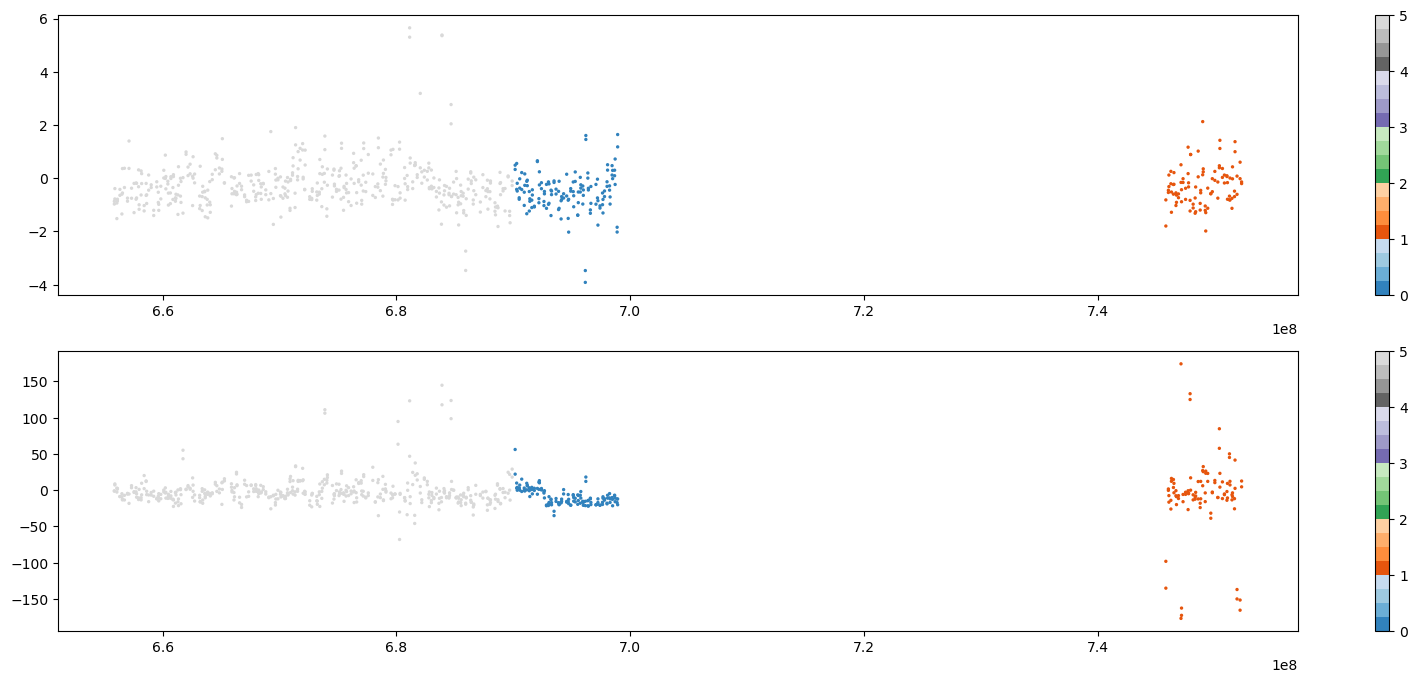

In [6]:
lat = -2
lon = 165

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
plotTimeSeriesAllClusterLabel(df, lat, lon, axes[0], axes[1])

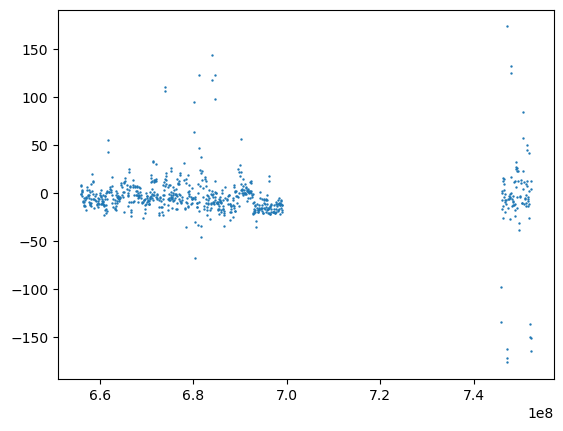

In [7]:
lat = -2
lon = 165

subDF = df.loc[df['lat'] == lat]
subDF = subDF.loc[subDF['lon'] == lon%360]

#plt.scatter(subDF['time'], subDF['speedDiff'], s = 0.5)
plt.scatter(subDF['time'], subDF['directionDiff'], s = 0.5)
subDF = subDF.loc[subDF['Deployment Classifier']==3]
#plt.scatter(subDF['time'], subDF['speedDiff'], s = 0.5)
plt.scatter(subDF['time'], subDF['directionDiff'], s = 0.5)


In [8]:
lat = -2
lon = 165

LAT = lat
LON = lon

if lat < 0:
    latUnits = 'S'
else:
    latUnits = 'N'

if lon < 0:
    lonUnits = 'W'
    LON += 360
else:
    lonUnits = 'E'

lat=abs(lat)
lon=abs(lon)

fname = f'../../downloads/Buoy/extractedGZ2/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2007.nc'
deployFileName = f'../../downloads/Buoy/extractedGZ2/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
ds= Dataset(fname)
timeUnits = ds.variables['time'].units
depDS = Dataset(deployFileName)

In [9]:
xrds = xr.open_dataset(fname)
ds = Dataset(fname)
xrds

<xarray.Dataset>
Dimensions:                  (time: 1195, N: 4)
Coordinates:
  * time                     (time) datetime64[ns] 2007-01-03T22:40:00 ... 20...
Dimensions without coordinates: N
Data variables: (12/15)
    U10N_AS                  (N, time) float64 ...
    U10N_dir_AS              (N, time) float64 ...
    satTimeDiff              (N, time) timedelta64[ns] ...
    dist                     (N, time) float64 ...
    satLon                   (N, time) float64 ...
    satLat                   (N, time) float64 ...
    ...                       ...
    RH_TAO                   (time) float64 ...
    AIRT_TAO                 (time) float64 ...
    wspdVar2hr_TAO           (time) float64 ...
    wdirVar2hr_TAO           (time) float64 ...
    U10N_TAO                 (time) float64 ...
    U10N_dir_TAO             (time) float64 ...

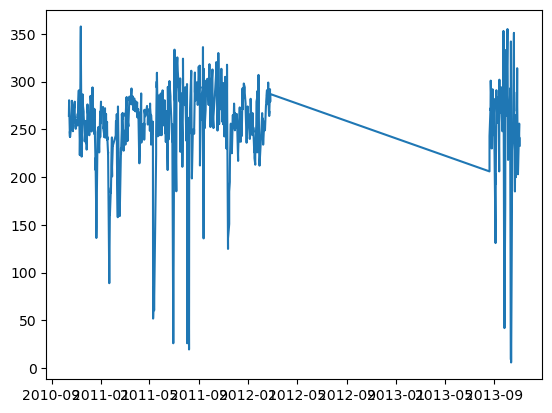

In [10]:
plt.plot(xrds['time'], xrds['U10N_dir_TAO'])
#plt.plot(xrds['time'], xrds['U10N_TAO'])
#plt.plot(newXds['time'], newXds['U10N_TAO'])

In [11]:
cftimes = num2date(subDF['time'], timeUnits)
subDSTime = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

cftimes  = num2date(ds['time'], timeUnits)
dsTime = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])


In [12]:
subDSTime[0], subDSTime[-1]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
mask1 = dsTime >= subDSTime[0]

mask2 = dsTime <= subDSTime[-1]

mask = mask1 * mask2

#mask = np.logical_and(dsTime >= subDSTime[0], dsTime <= subDSTime[-1])
plt.plot(dsTime, mask1)
plt.plot(dsTime, mask2)
plt.plot(dsTime, mask)

In [ ]:
U10N_TAO = xrds['U10N_TAO'].to_numpy().copy()
U10N_dir_TAO = xrds['U10N_dir_TAO'].to_numpy().copy()

U10N_TAO[mask] = float('nan')
U10N_dir_TAO[mask] = float('nan')

newXds = xrds.rename({'U10N_TAO': 'U10N_TAO_withErrors',
                      'U10N_dir_TAO': 'U10N_dir_TAO_withErrors'})

newXds['U10N_TAO'] = (('time'), U10N_TAO)
newXds['U10N_dir_TAO'] = (('time'), U10N_dir_TAO)

plt.plot(U10N_dir_TAO)
#plt.plot(U10N_TAO)

In [ ]:
newXds

In [ ]:
plt.plot(xrds['time'], xrds['U10N_dir_TAO'])
plt.plot(newXds['time'], newXds['U10N_dir_TAO'])

# plt.plot(xrds['time'], xrds['U10N_TAO'])
# plt.plot(newXds['time'], newXds['U10N_TAO'])

In [ ]:
lat = -2
lon = 165

LAT = lat
LON = lon

if lat < 0:
    latUnits = 'S'
else:
    latUnits = 'N'

if lon < 0:
    lonUnits = 'W'
    LON += 360
else:
    lonUnits = 'E'

lat=abs(lat)
lon=abs(lon)

wfname = f'../../downloads/Buoy/extractedGZ2/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2007_errRemoved.nc'
newXds.to_netcdf(wfname)